In [1]:
from moist_konrad_Cshape import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [2]:
# 1. RLS = 1/1 same, less humid UTH (0.9 RHs) more solar constants and cold point as 125hPa, 
#last one bad, redid it by making rh at greater than 0.0001 everywhere, and not fixed vmr above coldpoint
# 2. RLS = 1/2
# 3. RLS = 1/3


results_file = open("results-strong-Cshape-3.txt",'w')
lambda_file = open("lambda-strong-Cshape-3.txt",'w')
temp_file = open("temp_file-strong-Cshape-3.txt",'w')
water_file = open("water-strong-Cshape-3.txt",'w')

In [3]:
cases = [1.]
initial_temperatures = [270.]
depths = [2.5]

initial_rh = [0.6]

RLS = 1/3

solar_multiplier = np.linspace(0.799,1.1,60)
print(solar_multiplier)

land_atm_coupling = True
strong_coupling = True

albedo_sfc = 0.2

[0.799      0.80410169 0.80920339 0.81430508 0.81940678 0.82450847
 0.82961017 0.83471186 0.83981356 0.84491525 0.85001695 0.85511864
 0.86022034 0.86532203 0.87042373 0.87552542 0.88062712 0.88572881
 0.89083051 0.8959322  0.9010339  0.90613559 0.91123729 0.91633898
 0.92144068 0.92654237 0.93164407 0.93674576 0.94184746 0.94694915
 0.95205085 0.95715254 0.96225424 0.96735593 0.97245763 0.97755932
 0.98266102 0.98776271 0.99286441 0.9979661  1.0030678  1.00816949
 1.01327119 1.01837288 1.02347458 1.02857627 1.03367797 1.03877966
 1.04388136 1.04898305 1.05408475 1.05918644 1.06428814 1.06938983
 1.07449153 1.07959322 1.08469492 1.08979661 1.09489831 1.1       ]


In [4]:
%%time

for k in range(len(solar_multiplier)):
    for rhi in range(len(initial_rh)):
        for de in range(len(depths)):
            for te in range(len(initial_temperatures)):
                print(depths[de],initial_temperatures[te],solar_multiplier[k],initial_rh[rhi])
                ###PARAMETERS OF THE TEST:

                #flux for efficiency computation:
                # 1: LH + SH
                # 2: Radiation surface
                # 3: Atmosphere radiation
                case = cases[0]
                depth_d = depths[de]
                ini_rh = initial_rh[rhi]


                #coupled surface-atmosphere: 
                #if true, surface fluxes and surface temperature change at each step, constant otherwise
                coupled = land_atm_coupling

                SH_f = 15.
                LH_f = 140.
                Ts_f = np.array([initial_temperatures[te]])
                print(Ts_f)

                #Strong coupling surface-atmosphere:
                #If true the atmosphere moist adiabat starts at surface temperature
                #If false find the atmopsheric moist adiabat that conserves energy
                strong = strong_coupling

                popke = True
                if popke == True:
                    solar = 510. * solar_multiplier[k]
                    angle = 47.9
                else:
                    solar = 480.* solar_multiplier[k]
                    angle = 42.05

                A = albedo_sfc

                ### INITIALIZATION
                E_imbalance = 0.

                plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
                atmosphere = konrad.atmosphere.Atmosphere(phlev)
                clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
                surface = konrad.surface.SlabOcean(
                    temperature=288,
                    heat_sink=0,
                    depth = depth_d,
                    albedo = 0.5)

                radiation = konrad.radiation.RRTMG(solar_constant=solar, zenith_angle = angle)

                ndays = 10000
                timestep = 0.5 #days
                nsteps = int(ndays/timestep)

                printcounter = 0
                status = 0

                tol = 1e-5

                ### RCPE COMPUTATION

                surface['temperature'] = Ts_f
                surface.albedo = A
                ini_T_atm = atmosphere['T'][0].copy()
                
                atmosphere['T'][0] = moist_adiabat(surface['temperature'],ini_T_atm,atmosphere)
                print(surface['temperature'],surface.albedo)

                conv_top = convective_top(atmosphere['T'][0],ini_T_atm,atmosphere['plev'])
                RH = manabe_rh(ini_rh,atmosphere['plev'], conv_top)
                atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
                T_atm_low = surface['temperature']

                print(surface['temperature'],surface.albedo)

                #### RCE FOR PRESENT-DAY CO2
                atmosphere['CO2'][0] = 348/1e6


                T_sfc_1 = [1e8]
                toa_1 = [1e8]
                for i in range(nsteps):
                    #surface fluxes
                    z = height(atmosphere['plev'],atmosphere['T'][0],
                               atmosphere['phlev'][0],surface['temperature'])


                    T_ini,vmr_ini = atmosphere['T'][0][0].copy(),atmosphere['H2O'][0,0].copy()

                    #compute the fluxes or input the forcing
                    if coupled == True:
                        LH = latent_heat(vmr_ini, T_ini,atmosphere['phlev'][0],RLS)
                        SH = sensible_heat(T_ini,surface['temperature'],atmosphere['phlev'][0],RLS)

                    else:
                        LH = LH_f
                        SH = SH_f


                    #convective adjustment of the armosphere
                    atmosphere,surface,radiation,net_rad_surface,atm_rad,\
                    T_atm_low,E_imbalance,prec_mass,prec_heating,\
                    RH,cold_point,prec_eff,water_content = RCPE_step_DSE(timestep,
                                                          atmosphere,surface,radiation,clearsky,
                                                          SH,LH,A,T_atm_low,
                                                          strong_coupling = strong,
                                                          constrain_RH = True,
                                                        Flux_case = case)



                    #update surface temperature with energetic fluxes (latent and radiative)
                    if coupled == True:
                        surface['temperature'] = surface['temperature'] + ((net_rad_surface - SH - LH)
                                               * seconds_day * timestep / surface.heat_capacity)

                    else:
                        surface['temperature'] = Ts_f


                    status += 1
                    if printcounter == 200:
                        print(status/2)
                    printcounter += 1

                    T_sfc_1.append(surface['temperature'])
                    toa_1.append(radiation['toa'].copy())
                    if abs(T_sfc_1[i]-T_sfc_1[i-1])<tol and abs(toa_1[i]-toa_1[i-1])<tol:
                        print(i)
                        break

                print('hehe')
                olr_rec = radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy()
                net_sw = radiation['sw_flxd'][0,-1].copy() - radiation['sw_flxu'][0,-1].copy()
                isr_rec = radiation['sw_flxd'][0,-1].copy()
                results_file.write(str(depth_d)+" "+str(case)+" "+str(Ts_f[0])
                                   +" "+str(surface['temperature'][0])+" "+str(T_ini)
                                   +" "+str(net_rad_surface)+" "+str(atm_rad)+" "+str(radiation['toa'][0])
                                   +" "+str(olr_rec)+" "+str(net_sw)+" "+str(isr_rec)
                                   +" "+str(E_imbalance[0])
                                   +" "+str(LH)+" "+str(SH[0])+" "+str(prec_eff[0])
                                   +" "+str(prec_mass[0])+" "+str(LH/Lv * seconds_day)
                                   +" "+str(RH[0])+" "+str(water_content[0])+" "+str(ini_rh)
                                   +" "+str(atmosphere['CO2'][0][0])
                                   +"\n")

                if de == 0 and te == 0:
                    np.savetxt(temp_file,atmosphere['T'][0].reshape(1, -1).copy())
                    np.savetxt(water_file,atmosphere['H2O'][0].reshape(1, -1).copy())

                P1 = prec_mass
                q1 = atmosphere['H2O'][0].copy()[0]
                RH1 = RH[0]
                
                print(RH1, radiation['toa'], E_imbalance, surface['temperature'])

                #### RCE FOR PRESENT-DAY CO2
                atmosphere['CO2'][0] *= 2


                T_sfc_2 = [1e8]
                toa_2 = [1e8]
                olr_2 = [1e8]
                for i in range(nsteps):
                    #surface fluxes
                    z = height(atmosphere['plev'],atmosphere['T'][0],
                               atmosphere['phlev'][0],surface['temperature'])
                    
                    T_ini,vmr_ini = atmosphere['T'][0][0].copy(),atmosphere['H2O'][0,0].copy()

                    #compute the fluxes or input the forcing
                    if coupled == True:
                        LH = latent_heat(vmr_ini, T_ini,atmosphere['phlev'][0],RLS)
                        SH = sensible_heat(T_ini,surface['temperature'],atmosphere['phlev'][0],RLS)

                    else:
                        LH = LH_f
                        SH = SH_f


                    #convective adjustment of the armosphere
                    atmosphere,surface,radiation,net_rad_surface,atm_rad,\
                    T_atm_low,E_imbalance,prec_mass,prec_heating,\
                    RH,cold_point,prec_eff,water_content = RCPE_step_DSE(timestep,
                                                          atmosphere,surface,radiation,clearsky,
                                                          SH,LH,A,T_atm_low,
                                                          strong_coupling = strong,
                                                          constrain_RH = True,
                                                        Flux_case = case)



                    #update surface temperature with energetic fluxes (latent and radiative)
                    if coupled == True:
                        surface['temperature'] = surface['temperature'] + ((net_rad_surface - SH - LH)
                                               * seconds_day * timestep / surface.heat_capacity)

                    else:
                        surface['temperature'] = Ts_f



                    status += 1
                    if printcounter == 200:
                        print(status/2)
                    printcounter += 1

                    T_sfc_2.append(surface['temperature'])
                    toa_2.append(radiation['toa'].copy())
                    olr_2.append(radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy())

                    if abs(T_sfc_2[i]-T_sfc_2[i-1])<tol and abs(toa_2[i]-toa_2[i-1])<tol:
                        print(i)
                        break

                print('hehe2')
                olr_rec = radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy()
                net_sw = radiation['sw_flxd'][0,-1].copy() - radiation['sw_flxu'][0,-1].copy()
                isr_rec = radiation['sw_flxd'][0,-1].copy()
                results_file.write(str(depth_d)+" "+str(case)+" "+str(Ts_f[0])
                                   +" "+str(surface['temperature'][0])+" "+str(T_ini)
                                   +" "+str(net_rad_surface)+" "+str(atm_rad)+" "+str(radiation['toa'][0])
                                   +" "+str(olr_rec)+" "+str(net_sw)+" "+str(isr_rec)
                                   +" "+str(E_imbalance[0])
                                   +" "+str(LH)+" "+str(SH[0])+" "+str(prec_eff[0])
                                   +" "+str(prec_mass[0])+" "+str(LH/Lv * seconds_day)
                                   +" "+str(RH[0])+" "+str(water_content[0])+" "+str(ini_rh)
                                   +" "+str(atmosphere['CO2'][0][0])
                                   +"\n")

                if de == 0 and te == 0:
                    np.savetxt(temp_file,atmosphere['T'][0].reshape(1, -1).copy())
                    np.savetxt(water_file,atmosphere['H2O'][0].reshape(1, -1).copy())

                P2 = prec_mass
                q2 = atmosphere['H2O'][0].copy()[0]
                RH2 = RH[0]

                print(RH2, radiation['toa'], E_imbalance, surface['temperature'])
                
                T1 = T_sfc_1[-1]
                T2 = np.array(T_sfc_2[1:])
                toa2 = np.array(toa_2[1:])
                olr2 = np.array(olr_2[1:])


                T_anom = T2 - T1

                regres_1 = linregress( T_anom[200:,0], toa2[200:,0])
                regres_2 = linregress( T_anom[200:,0], olr2[200:])
                
                lambda_1 = regres_1.slope
                lambda_2 = regres_2.slope
                rval_1 = regres_1.rvalue
                rval_2 = regres_2.rvalue


                lambda_file.write(str(depth_d)+" "+str(case)+" "+str(Ts_f[0])
                                 +" "+str(olr_rec)+" "+str(net_sw)+" "+str(isr_rec)
                                 +" "+str(T_anom[-1][0])
                                 +" "+str(lambda_1)+" "+str(rval_1)
                                 +" "+str(lambda_2)+" "+str(rval_2)
                                 +" "+str(((P2-P1)/P1*100/T_anom[-1])[0])
                                 +" "+str((q2-q1)/q1*100/T_anom[-1][0])
                                 +" "+str(np.max(toa2))+" "+str(np.min(olr2))
                                 +"\n")
    


2.5 270.0 0.799 0.6
[270.]
[270.] 0.2
[270.] 0.2
100.5
979
hehe
0.6815616278893267 [-0.00033997] [-0.01962369] [267.45526263]
790
hehe2
0.6421291584591504 [0.00176334] [0.00597057] [268.83530796]
2.5 270.0 0.8041016949152543 0.6
[270.]
[270.] 0.2
[270.] 0.2
100.5
1035
hehe
0.6687748412078137 [-4.37058519e-05] [-0.0122976] [267.99688871]
783
hehe2
0.6327120972916058 [0.00281486] [0.00601487] [269.40491161]
2.5 270.0 0.8092033898305085 0.6
[270.]
[270.] 0.2
[270.] 0.2
100.5
980
hehe
0.6572107276154092 [-0.00199345] [-0.01855943] [268.54085846]
809
hehe2
0.6244600810201367 [0.00288058] [0.00518459] [269.98137368]
2.5 270.0 0.8143050847457628 0.6
[270.]
[270.] 0.2
[270.] 0.2
100.5
995
hehe
0.6467377748056565 [-0.00223068] [-0.01615354] [269.08964015]
812
hehe2
0.6173143560622095 [0.00303445] [0.00487526] [270.56086112]
2.5 270.0 0.819406779661017 0.6
[270.]
[270.] 0.2
[270.] 0.2
100.5
1000
hehe
0.637519296216749 [-0.00254471] [-0.01546391] [269.64269333]
874
hehe2
0.6111297664481837 [0.002

100.5
1520
hehe
0.6519053184555926 [0.00354071] [0.00324923] [290.92033289]
1429
hehe2
0.6663867775338997 [0.00436737] [0.00357694] [293.12509886]
2.5 270.0 1.0030677966101695 0.6
[270.]
[270.] 0.2
[270.] 0.2
100.5
1522
hehe
0.6546532350611232 [0.00408419] [0.0036886] [291.5459922]
1454
hehe2
0.6690234874783307 [0.00442304] [0.00369891] [293.76702521]
2.5 270.0 1.0081694915254238 0.6
[270.]
[270.] 0.2
[270.] 0.2
100.5
1571
hehe
0.6573402805648982 [0.00410163] [0.00344746] [292.17368161]
1468
hehe2
0.6716651026242275 [0.00481472] [0.00303563] [294.41299729]
2.5 270.0 1.013271186440678 0.6
[270.]
[270.] 0.2
[270.] 0.2
100.5
1598
hehe
0.6599605275292392 [0.00429622] [0.00366774] [292.80275956]
1543
hehe2
0.6742727845045776 [0.00451527] [0.00357567] [295.06356544]
2.5 270.0 1.0183728813559323 0.6
[270.]
[270.] 0.2
[270.] 0.2
100.5
1695
hehe
0.6625647210716202 [0.00335255] [0.00322103] [293.43466183]
1579
hehe2
0.6769478272388396 [0.00462688] [0.00376988] [295.72090369]
2.5 270.0 1.02347457

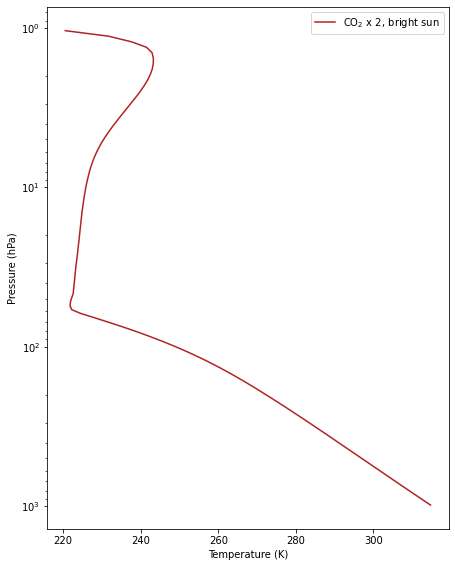

In [5]:
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))

p,ph = konrad.utils.get_pressure_grids(1000e2, 100, 128)

ax.plot(atmosphere['T'][0], p/100,
               alpha = 1, color = 'firebrick', lw = 1.5, label = 'CO$_2$ x 2, bright sun')


ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()

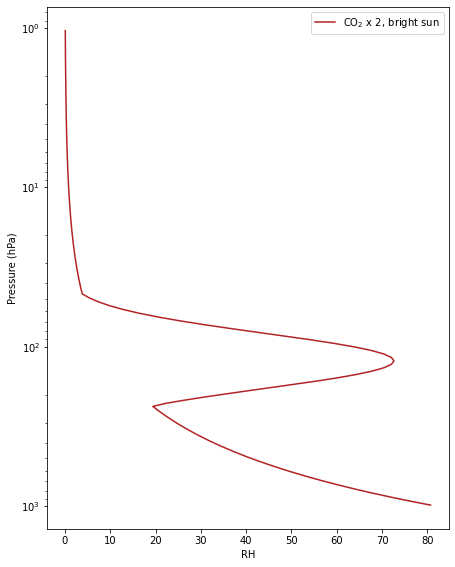

In [6]:
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))

p,ph = konrad.utils.get_pressure_grids(1000e2, 100, 128)

ax.plot(RH*100, p/100,
               alpha = 1, color = 'firebrick', lw = 1.5, label = 'CO$_2$ x 2, bright sun')


ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('RH')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()

In [7]:
temp_file.close()
water_file.close()
results_file.close()
lambda_file.close()

In [8]:
print(T_anom[200:,0])

[1.18407889 1.18932096 1.1945534  ... 9.60391188 9.60392157 9.60393293]


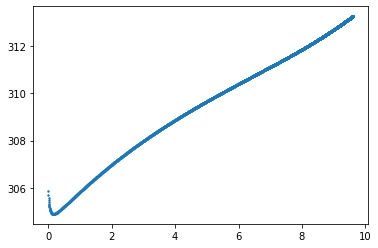

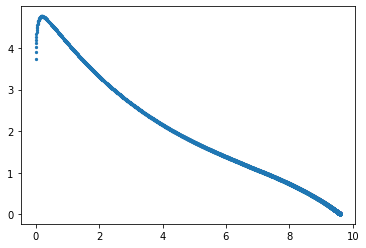

In [9]:
plt.scatter(T_anom[:,0], olr2[:], s = 2)
plt.show()
plt.scatter(T_anom[:,0], toa2[:,0], s = 5)
plt.show()

In [10]:
lambda_1 = linregress( T_anom[500:,0], toa2[500:,0]).slope
lambda_2 = linregress( T_anom[500:,0], olr2[500:]).slope
print(lambda_1,lambda_2)

-0.3830210038101649 0.7854797832653729


In [11]:
print(radiation['sw_flxd'][0,-1])

376.1085841075586


In [12]:
print(plev)
print(phlev)
print(z)

[98649.49096825 95982.70677655 93348.64798487 90748.60669154
 88183.79685561 85655.35445494 83164.33780182 80711.72801105
 78298.42961472 75925.27131802 73593.00689003 71302.31618318
 69053.80627507 66848.01272581 64685.40094449 62566.3676576
 60491.24247274 58460.28953049 56473.7092376  54531.6400743
 52634.1604689  50781.29073271 48972.99504834 47209.18350463
 45489.71417153 43814.39520823 42182.98699838 40595.20430578
 39050.71844465 37549.15945857 36090.11830215 34673.14902021
 33297.77091887 31963.47072369 30669.70471994 29415.90087041
 28201.46090639 27025.7623878  25888.16072851 24787.99118341
 23724.57079381 22697.20028815 21705.16593514 20747.74134695
 19824.18923    18933.7630813  18075.70882874 17249.26641353
 16453.6713136  15688.15600694 14951.95137381 14244.28803738
 13564.39764219 12911.51407038 12284.87459539 11683.7209735
 11107.30047334 10554.86684393 10025.68122188  9519.01297839
  9034.14050716  8570.35195402  8126.94588956  7703.23192601
  7298.53127956  6912.17727